In [1]:
from preprocessing_utils import *
import os
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F

In [2]:
df_stats = get_game_data()
Y = df_stats['Team1 result']
labelencoder = LabelEncoder()
Y = labelencoder.fit_transform(Y)

df_stats = df_stats.loc[:, df_stats.columns.str.contains('Norm')]

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(df_stats, Y, test_size=0.10, random_state=101 )

pca = PCA(0.99)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

X_train = pd.DataFrame(data = X_train, columns = ['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11', 'PC12'])
X = X_train.values
Y = Y_train

In [4]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        num_nodes = 50
        nfeatures = 12
        self.input = nn.Linear(nfeatures, num_nodes)
        self.hidden1 = nn.Linear(num_nodes, num_nodes)
        self.output = nn.Linear(num_nodes, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.input(x)
        x = F.relu(x)
        x = F.dropout(x, p = 0.5)
        x = self.hidden1(x)
        x = F.relu(x)
        x = F.dropout(x, p = 0.5)
        x = self.output(x)
        x = self.sigmoid(x)
        
        return x

In [5]:
from sklearn.model_selection import KFold

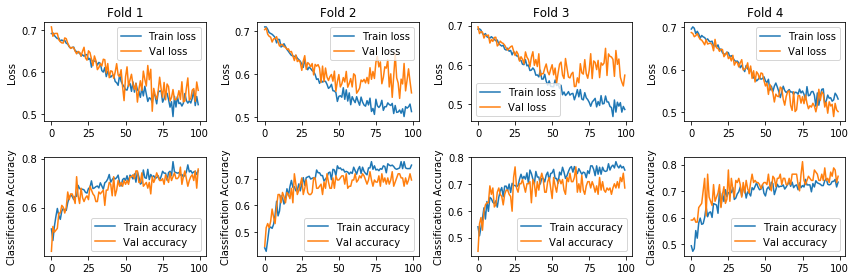

Best Val accuracy 0.8110
Avg Train accuracy 0.7706
Avg Val accuracy 0.7667


In [20]:
loss_func = nn.BCELoss()
learning_rate = 0.001

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
max_val_accuracies = []
max_train_accuracies = []
iters = 100

cv = KFold(n_splits = 4, random_state=42, shuffle=True)
best_acc = 0
best_model = None
best_iter = 0

for train_index, val_index in cv.split(X):
    X_train, X_val, y_train, y_val = X[train_index], X[val_index], Y[train_index], Y[val_index]
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.FloatTensor(y_train).reshape(-1, 1)
    X_val_t = torch.FloatTensor(X_val)
    y_val_t = torch.FloatTensor(y_val).reshape(-1, 1)
        
    cval_acc, cval_loss, train_acc, train_loss = [], [], [], []
    
    model = Network()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for i in range(iters):
        model.train()
        
        y_hat = model(X_train_t)
        loss = loss_func(y_hat, y_train_t)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        y_hat_class = np.where(y_hat.detach().numpy()<0.5, 0, 1)
        accuracy = np.sum(y_train.reshape(-1, 1) == y_hat_class) / len(y_train)
        
        train_acc.append(accuracy)
        train_loss.append(loss.item())
        
        model.eval()
        y_hat = model(X_val_t)
        loss = loss_func(y_hat, y_val_t)
        y_hat_class = np.where(y_hat.detach().numpy()<0.5, 0, 1)
        accuracy = np.sum(y_val.reshape(-1, 1) == y_hat_class) / len(y_val)
        
        cval_acc.append(accuracy)
        cval_loss.append(loss.item())
    
    max_acc_train = max(train_acc)
    max_acc_val = max(cval_acc)
    if max_acc_val > best_acc:
        best_acc = max_acc_val
        best_model = model
        best_iter = cval_acc.index(max_acc_val)
    
    max_val_accuracies.append(max_acc_val)  
    max_train_accuracies.append(max_acc_train)
    val_accuracies.append(cval_acc)
    val_losses.append(cval_loss)
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)
      
fig, ax = plt.subplots(2, 4, figsize=(12,4))

for i in range(4):
    ax[0][i].set_title('Fold ' + str(i+1))
    ax[0][i].plot(train_losses[i], label='Train loss')
    ax[0][i].plot(val_losses[i], label='Val loss')
    ax[0][i].set_ylabel('Loss')
    ax[0][i].legend()
    
    ax[1][i].plot(train_accuracies[i], label='Train accuracy')
    ax[1][i].plot(val_accuracies[i], label='Val accuracy')
    ax[1][i].set_ylabel('Classification Accuracy')
    ax[1][i].legend()

plt.tight_layout()
plt.show()
print("Best Val accuracy {:.4f}".format(best_acc))
print("Avg Train accuracy {:.4f}".format(sum(max_train_accuracies) / len(max_train_accuracies)))
print("Avg Val accuracy {:.4f}".format(sum(max_val_accuracies) / len(max_val_accuracies)))

In [42]:
X_test_t = torch.FloatTensor(X_test)
y_hat_test = best_model(X_test_t)
y_hat_test_class = np.where(y_hat_test.detach().numpy()<0.5, 0, 1)
test_accuracy = np.sum(Y_test.reshape(-1,1)==y_hat_test_class) / len(Y_test)
print("Test Accuracy {:.2f}".format(test_accuracy))

Test Accuracy 0.81


In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, y_hat_test_class)

array([[27,  3],
       [ 8, 19]])